  # Dataset reviews_eng_courses from the Coursera website

ИСТОЧНИК бд - отзывы пользователей образовательного портала Coursera по англоязычным курсам (спарсили с сайта Coursera) 
http://localhost:8888/edit/Desktop/Netology/Rec_sys/Rec_Sys_PROJECT/reviews_eng_courses.csv

- url - URL of the course in the Coursera website 
- course_id - This is a part of the URL of the course in the Coursera website. 
For example, in this URL, machine-learning would be the course tag for https://www.coursera.org/learn/machine-learning.
- reviewer_name - имя пользователя, сотавившего отзыв
- rating - оценка, которую поставил пользователь курсу
- review_text - текст отзыва, который пользователь оставил курсу

Исходные данные - информация о 160 085 отзывах о 1298 курсах на английском языке.

Отрицательные примеры - отзывы с выставленными низкими оценками.

Дополнительная генерация отрицательных примеров не проводилась.

Дополнительные данные не использовались.

## inspiration:
Jan Charles Maghirang Adona scraped the website of Coursera and pre-labelled the dataset depending on their rating. For a 5-star rating, the review was labelled as Very Positive, Positive for 4-star, Neutral for 3-star, Negative for 2-star, and Very Negative for 1-star. 
https://www.kaggle.com/septa97/100k-courseras-course-reviews-dataset/downloads/100k-courseras-course-reviews-dataset.zip/2#reviews_by_course.csv There are 2 files, reviews.tsv and reviews_by_course.tsv. 
#The main problem in this dataset is its imbalanced nature.
For the reviews_by_course.tsv, they are grouped by the CourseId column.
- CourseId - The course tag. This is in the URL of the course in the Coursera website. For example, in this URL, machine-learning would be the course tag.
- Review - A review in a specific course.
- Label - The rating of the course review.

Для целей решения поставленной задачи (рекомендации курса на основании отзывов пользователей) данный датасет НЕ ПОДХОДИТ, т.к. отсутствует привязка оценок к пользователям, поставившим эту оценку - оценки обезличены и мы можем выявить только среднюю популярность каждого курса - это подойдёт только для рандомной рекомендации "в среднем хорошего курса"

Подготовка датасета
Очистка данных
Изменение размера датасета в ходе работы
Выбросы и работа с ними
Оценка качества

Проверка на опечатки - Яндекс спеллер - можно использовать как вариант дальнейшего улучшения 

Анализ тональностей слов - эмоциональная окраска
Важные слова и удаление неважных слов - как меняет результат
Собрать словарь

Разделение по классам: For a 5-star rating, the review was labelled as Very Positive, Positive for 4-star, Neutral for 3-star, Negative for 2-star, and Very Negative for 1-star.

Готовые решения - как делают оценку по тональности (нейросети, мешок слов и логистич регр) 
Фрагментарный анализ отзывов по фразам, капслоку и символам

In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import datetime
import time
import re
import seaborn as sns
import multiprocessing

import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm
tqdm.pandas(desc="progress-bar")

import gensim
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

from nltk.corpus import stopwords
from nltk.stem.snowball import EnglishStemmer

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import xgboost
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats


from sklearn import utils
from sklearn.metrics import accuracy_score, f1_score, brier_score_loss
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression

#### Загрузка и анализ данных

In [2]:
#рассмотрим датасет с отзывами по англоязычным курсам
reviews_eng_courses = pd.read_csv('reviews_eng_courses.csv')
reviews_eng_courses.head()

,url,course_id,reviewer_name,rating,review_text
0,https://www.coursera.org/learn/2-speed-it/revi...,2-speed-it,Ravish,5,Very relevant and useful course designed for CIOs
1,https://www.coursera.org/learn/2-speed-it/revi...,2-speed-it,Etienne R,2,This course does not say anything about digiti...
2,https://www.coursera.org/learn/2-speed-it/revi...,2-speed-it,Viswas P,4,Videos that are presented in French could've b...
3,https://www.coursera.org/learn/2-speed-it/revi...,2-speed-it,AN L,3,"The course content is quite good, though it co..."
4,https://www.coursera.org/learn/2-speed-it/revi...,2-speed-it,Konstantin A,5,"Great piece of work, I especially liked a few ..."


In [3]:
reviews_eng_courses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160092 entries, 0 to 160091
Data columns (total 5 columns):
url              160092 non-null object
course_id        160092 non-null object
reviewer_name    159841 non-null object
rating           160092 non-null int64
review_text      160085 non-null object
dtypes: int64(1), object(4)
memory usage: 6.1+ MB


In [4]:
#количество уникальных курсов
reviews_eng_courses.course_id.nunique()

1298

In [5]:
#пропущенное имя пользователя делает отзыв бесполезным для наших целей
reviews_eng_courses['reviewer_name'] = reviews_eng_courses.reviewer_name.fillna(value = 'NaN')
#заполним пропущенные значения
reviews_eng_courses['review_text'] = reviews_eng_courses.review_text.fillna(value = 'NaN')
reviews_eng_courses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160092 entries, 0 to 160091
Data columns (total 5 columns):
url              160092 non-null object
course_id        160092 non-null object
reviewer_name    160092 non-null object
rating           160092 non-null int64
review_text      160092 non-null object
dtypes: int64(1), object(4)
memory usage: 6.1+ MB


In [6]:
#проверим уникальность пользователей, заодно посмотрим по сколько отзывов оставил каждый пользователь
reviews_eng_courses["reviewer_name"].value_counts()

Deleted A           588
NaN                 251
JOHN Q              139
Jonathan G          126
Joy S               101
Richard H            66
Muhammad A           65
Michael B            61
Daniel C             60
David M              58
David H              58
Do H L               57
Michael S            56
Michael M            56
Daniel S             56
David S              54
David B              54
David D              50
Bart S               50
Jose A R N           47
James M              47
James S              46
Jason M              46
Daniel M             45
Bernard D V          45
John P               44
Ana R P              44
John C               44
David C              44
Mohammad A           42
                   ... 
Iqbal                 1
Robin                 1
Anton O               1
SIQI C                1
Dr N J T P            1
Dr R P                1
Ahmed E A T E         1
Momendes F d S        1
Robert U              1
Sirarpi               1
görkem a        

In [7]:
#Deleted A - это явно не уникальное имя пользователя - надо от него избавиться
#выберем строки (отзывы), чье значение столбца 'reviewer_name' не равно 'NaN' и 'Deleted A'
reviews_eng_courses = reviews_eng_courses.loc[(reviews_eng_courses['reviewer_name'] != 'NaN') &
                                              (reviews_eng_courses['reviewer_name'] != 'Deleted A')]

In [8]:
reviews_eng_courses.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159253 entries, 0 to 160091
Data columns (total 5 columns):
url              159253 non-null object
course_id        159253 non-null object
reviewer_name    159253 non-null object
rating           159253 non-null int64
review_text      159253 non-null object
dtypes: int64(1), object(4)
memory usage: 7.3+ MB


In [9]:
#избавимся от лишних столбцов
reviews_eng_courses=reviews_eng_courses.drop(['url'], axis=1)
#очищенный датасет
reviews_eng_courses.head(3)

,course_id,reviewer_name,rating,review_text
0,2-speed-it,Ravish,5,Very relevant and useful course designed for CIOs
1,2-speed-it,Etienne R,2,This course does not say anything about digiti...
2,2-speed-it,Viswas P,4,Videos that are presented in French could've b...


In [10]:
# посмотрим на гистограмму распределения оценок по всем курсам
reviews_eng_courses['rating'].value_counts()

5    118590
4     26303
3      7587
1      3516
2      3257
Name: rating, dtype: int64

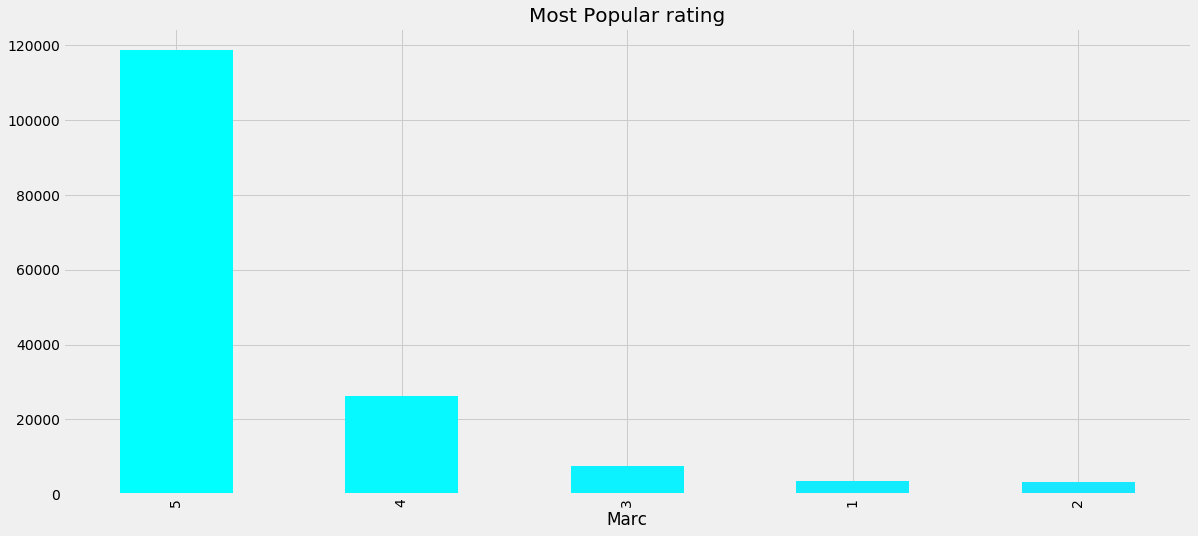

In [11]:
plt.rcParams['figure.figsize'] = (18, 8)
plt.style.use('fivethirtyeight')

color = plt.cm.cool(np.linspace(0, 2, 80))
reviews_eng_courses['rating'].value_counts().plot.bar(color = color)
plt.title('Most Popular rating', fontsize = 20, fontweight = 30)
plt.xlabel('Marc')
plt.show()

In [12]:
# Большинство англоязычных пользователей Coursera положительно отзываются о курсах - это прекрасно

In [13]:
#в %соотношении
reviews_eng_courses['rating'].value_counts(normalize = True)

5    0.744664
4    0.165165
3    0.047641
1    0.022078
2    0.020452
Name: rating, dtype: float64

In [14]:
# простые статистики по оценкам
reviews_eng_courses.describe()

,rating
count,159253.000000
mean,4.589885
std,0.851384
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


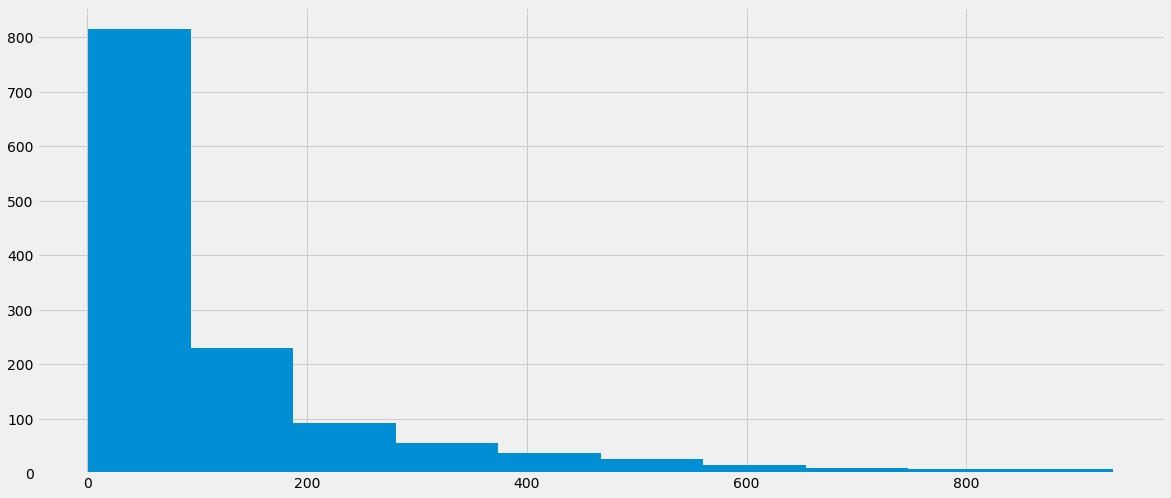

In [15]:
# меньше ста курсов имеет наибольшее количество оценок > 800
# гистограмма по количеству оценок на курс
reviews_eng_courses.groupby('course_id').rating.count().hist()

In [16]:
# Распределение признаков - course_id - количество ревью и оценок по каждому курсу
reviews_eng_courses['course_id'].value_counts()

matlab                                                934
project-management-basics                             927
game-development                                      911
data-cleaning                                         905
algorithmic-toolbox                                   894
data-science-course                                   879
science-of-meditation                                 871
mindshift                                             848
learn-to-program                                      808
language-theories                                     806
uva-darden-design-thinking-innovation                 796
philosophy                                            793
ml-regression                                         772
professional-emails-english                           768
website-coding                                        766
object-oriented-java                                  759
positive-psychology-visionary-science                 745
search-engine-

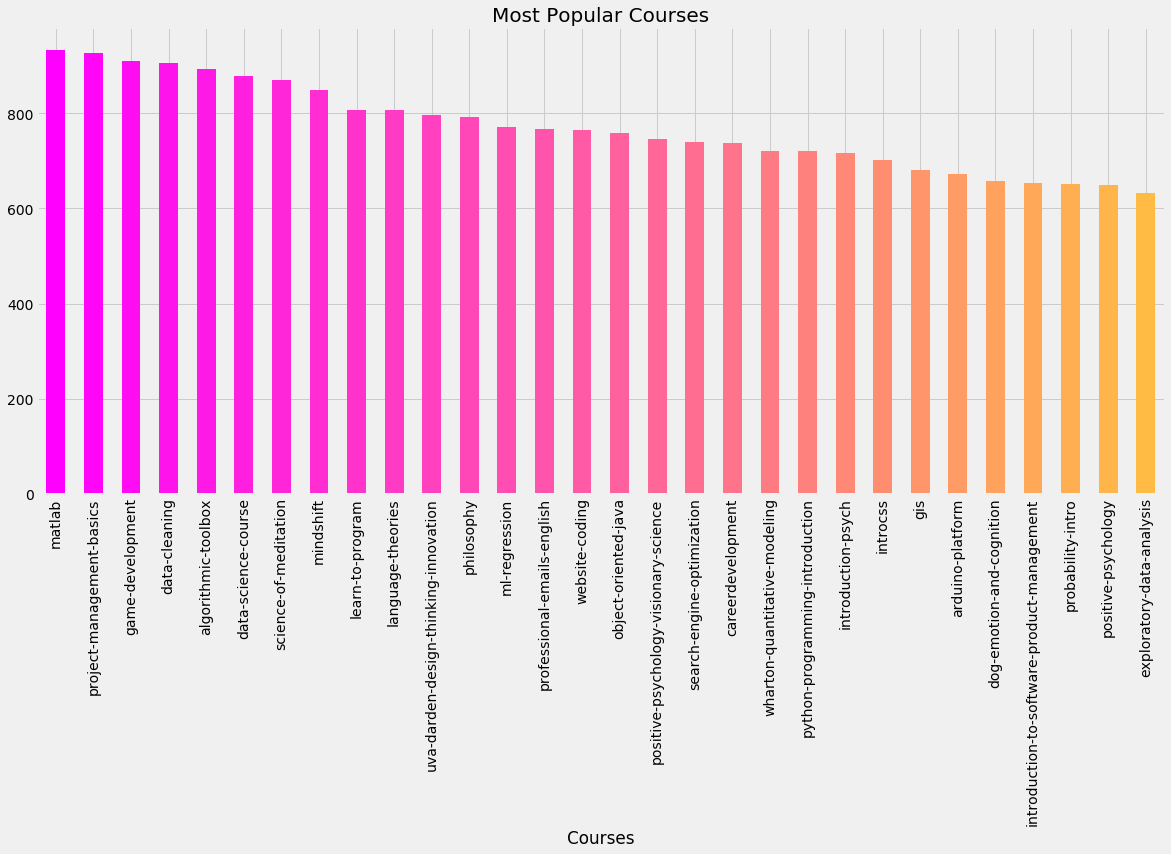

In [18]:
#визуализируем самые популярные курсы

plt.rcParams['figure.figsize'] = (18, 8)
plt.style.use('fivethirtyeight')

color = plt.cm.spring(np.linspace(0, 2, 80))
reviews_eng_courses['course_id'].value_counts().head(30).plot.bar(color = color)
plt.title('Most Popular Courses', fontsize = 20, fontweight = 30)
plt.xlabel('Courses')
plt.show()

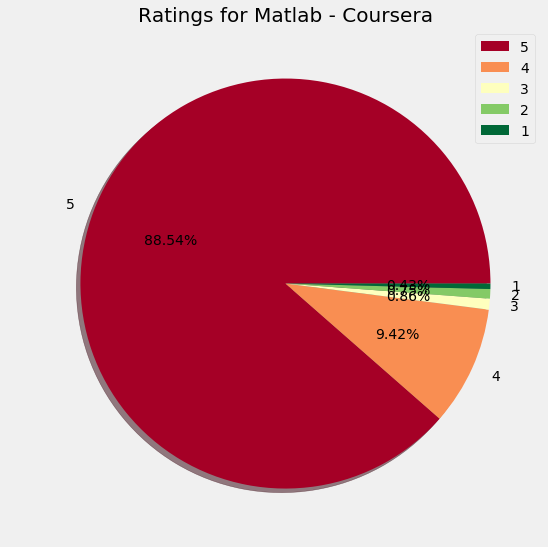

In [42]:
#визуализируем рейтинги курсов Matlab, machine learning, data science и python

plt.rcParams['figure.figsize'] = (18, 10)

rating_mat = reviews_eng_courses['rating'][reviews_eng_courses['course_id'] == 'matlab']
plt.subplot(1, 2, 1)
colors = plt.cm.RdYlGn(np.linspace(0, 1, 5))
rating_mat.value_counts().plot.pie(colors = colors,
                              labels = ['5', '4', '3', '2', '1'],
                               #explode = [0, 0, 0, 0.3, 0.5],
                              autopct = '%.2f%%', shadow = True)

plt.axis('off')
plt.title('Ratings for Matlab - Coursera', fontsize = 20)
plt.legend()

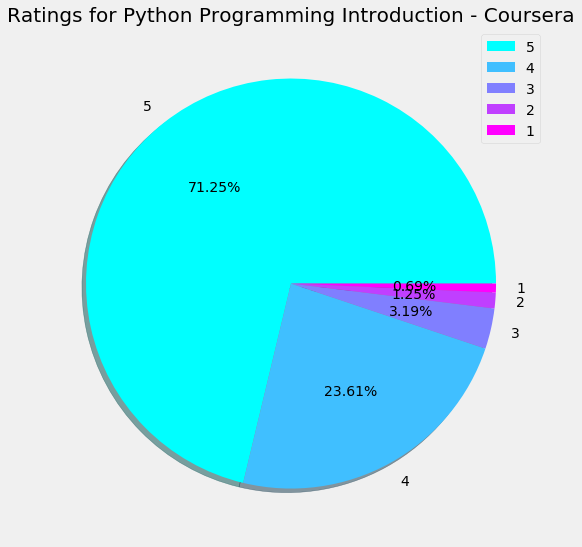

In [47]:

rating_py = reviews_eng_courses['rating'][reviews_eng_courses['course_id'] == 'python-programming-introduction']
plt.subplot(1, 2, 1)
colors = plt.cm.cool(np.linspace(0, 1, 5))
rating_py.value_counts().plot.pie(colors = colors,
                              labels = ['5', '4', '3', '2', '1'],
                               #explode = [0, 0, 0, 0.3, 0.5],
                              autopct = '%.2f%%', shadow = True)

plt.axis('off')
plt.title('Ratings for Python Programming Introduction - Coursera', fontsize = 20)
plt.legend()

In [48]:
reviews_eng_courses['rating'][reviews_eng_courses['course_id'] == 'python-programming-introduction'].value_counts()

5    513
4    170
3     23
1      9
2      5
Name: rating, dtype: int64

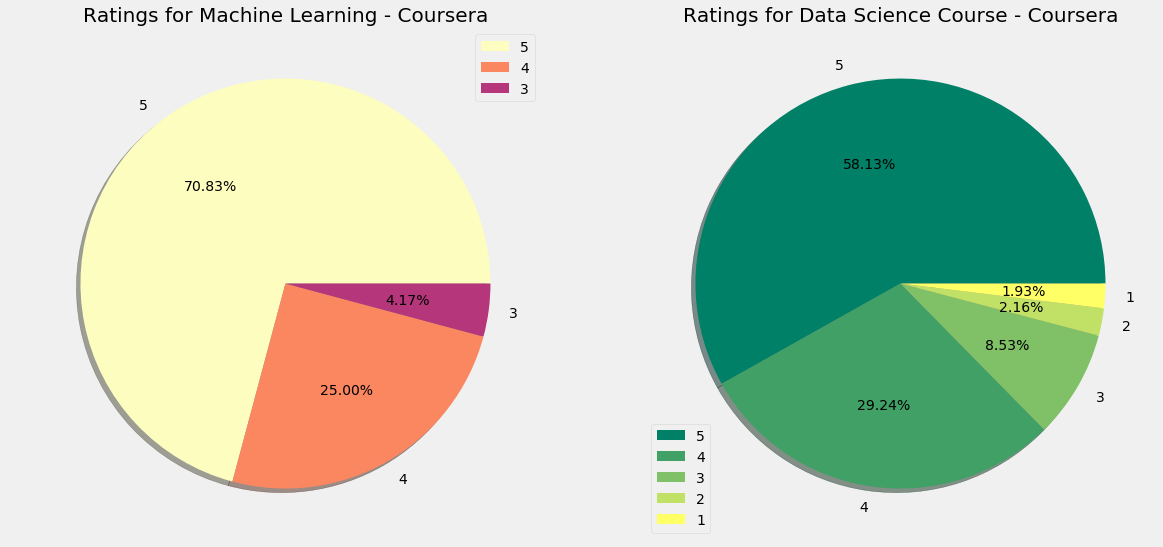

In [49]:
rating_ml = reviews_eng_courses['rating'][reviews_eng_courses['course_id'] == 'machine-learning']
plt.subplot(1, 2, 1)
colors = plt.cm.magma_r(np.linspace(0, 1, 5))
rating_ml.value_counts().plot.pie(colors = colors,
                              labels = ['5', '4', '3', '2', '1'],
                               #explode = [0, 0, 0, 0.3, 0.5],
                              autopct = '%.2f%%', shadow = True)

plt.axis('off')
plt.title('Ratings for Machine Learning - Coursera', fontsize = 20)
plt.legend()


ds_rating = reviews_eng_courses['rating'][reviews_eng_courses['course_id'] == 'data-science-course']
plt.subplot(1, 2, 2)
colors = plt.cm.summer(np.linspace(0, 1, 5))
ds_rating.value_counts().plot.pie(colors = colors,
                              labels = ['5', '4', '3', '2', '1'],
                               #explode = [0, 0, 0, 0.3, 0.5],
                              autopct = '%.2f%%', shadow = True)

plt.axis('off')
plt.title('Ratings for Data Science - Coursera', fontsize = 20)
plt.legend()

In [50]:
#review_text 140317 - есть пропущенные значения
#позволяет отобразить в т.ч. пропущенные значения - покажет что пропущено 3 значения
reviews_eng_courses["review_text"].value_counts(dropna = False) 

good                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

In [51]:
# Пользователи предпочитают оставлять краткие отзывы - рецензия 'good' была оставлена 608 раз

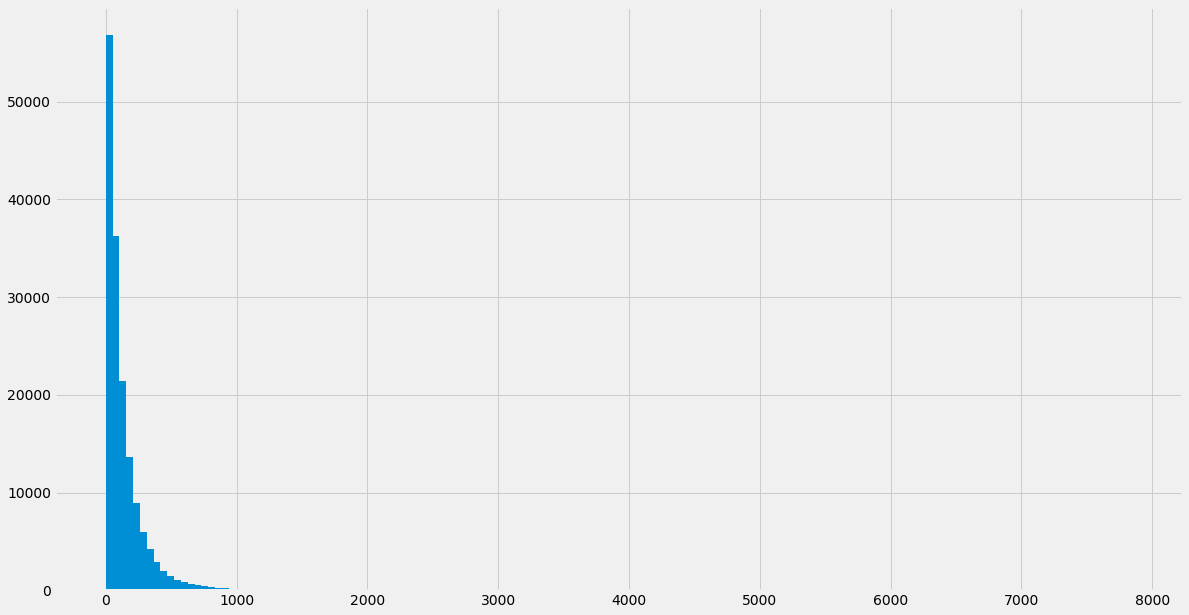

In [52]:
# визуализируем review по количеству символов
reviews_eng_courses.review_text.str.len().hist(bins=150)

In [53]:
# очевидный выброс по длине отзыва - однако эти отзывы являются информативными (даже через чур)
counter_long = 0
for i, text in reviews_eng_courses[reviews_eng_courses.review_text.str.len()>=5000].iterrows():
    counter_long+=1
    print("--- Abnormal large review: \n {0} \n".format(text['review_text']))

--- Abnormal large review: 
 Is this an educational course or an advertisement for Autodesk?  You will only experience and be told of Autodesk products:  Sketchbook, Tinkercad, and Fusion 360.  No other design programs are mentioned much less compared and contrasted.  No mention of Illustrator (vs Sketchbook), OpenSCAD (vs Tinkercad) or Solidworks (vs Fusion 360).  Set up in this manner, it shouldn't require a $79 Coursera fee given that this is setup to capture new students into Autodesk's product line.  Meshmixer is an Autodesk product and oddly isn't even mentioned, despite being widely used in the 3D printing community.

The course is overly focused on free-flowing design.  Despite being a 3D-design class made to be embedded in the 3D printing industry, you never have a video or assignment that has you make a part or item to specified measurements.  This is a real gap in the teachings; I would argue to have replaced Week 4 on sculpting with a module on adding dimensions and locking

In [54]:
# количество отзывов длиной >=5000 символов
print(counter_long)

6


In [55]:
#проверка выбросов среди кратких отзывов
counter_short = 0
for i, text in reviews_eng_courses[reviews_eng_courses.review_text.str.len()<=2].iterrows():
    counter_short+=1
    print("Very short review: \n {0} \n".format(text['review_text']))

Very short review: 
 . 

Very short review: 
 E 

Very short review: 
 g 

Very short review: 
 E 

Very short review: 
 很棒 

Very short review: 
 S 

Very short review: 
 F 

Very short review: 
 N 

Very short review: 
 A 

Very short review: 
 G 

Very short review: 
 H 

Very short review: 
 I 

Very short review: 
 L 

Very short review: 
 i 

Very short review: 
 . 

Very short review: 
 s 

Very short review: 
 I 

Very short review: 
 . 

Very short review: 
 aa 

Very short review: 
 l 

Very short review: 
 a 

Very short review: 
 E 

Very short review: 
 b 

Very short review: 
 - 

Very short review: 
 e 

Very short review: 
 . 

Very short review: 
 E 

Very short review: 
 B 

Very short review: 
 G 

Very short review: 
 Ex 

Very short review: 
 E 

Very short review: 
 V 

Very short review: 
 n 

Very short review: 
 G 

Very short review: 
 老师 

Very short review: 
 T 

Very short review: 
 D 

Very short review: 
 v 

Very short review: 
 e 

Very short review: 
 

In [56]:
#видим, что слишком короткие отзывы не несут смысловой нагрузки и бесполезны для наших целей, их в датасете:
len(reviews_eng_courses[reviews_eng_courses.review_text.str.len()<=2])

1361

In [57]:
#среди двубуквенных отзывов встречается формулировка "Ок" которую пользователи ставят в паре с разными оценками
short_rew = 'ok'
df_by_short_rew = []
filter_short_rew = reviews_eng_courses['review_text'] == short_rew
df_by_short_rew = reviews_eng_courses.loc[filter_short_rew]
df_by_short_rew

,course_id,reviewer_name,rating,review_text
26896,corporate-finance-essentials,Eduardo Z G,4,ok
30275,cyber-security-domain,Viviana N,5,ok
31631,data-cleaning,Amit K R,5,ok
32608,data-products,Amit K R,5,ok
32696,data-products,Reinhard S,5,ok
45248,epidemic-pandemic-outbreak,Piotr P,5,ok
49025,exploratory-data-analysis,Amit K R,5,ok
50722,finance-for-non-finance-managers,Christian P,5,ok
71217,interactive-python-2,Asfandyar M,5,ok
71301,interactive-python-2,NGUYEN K H,5,ok


In [58]:
short_rew = 'Ok'
filter_short_rew = reviews_eng_courses['review_text'] == short_rew
df_by_short_rew = df_by_short_rew.append(reviews_eng_courses.loc[filter_short_rew])
df_by_short_rew.tail()

,course_id,reviewer_name,rating,review_text
64653,horse-care,JoAnne M F,5,Ok
89136,marketing-analytics,Samik D,3,Ok
93836,microeconomics,Issah Q,5,Ok
113856,presentation-design,Ken D,4,Ok
138836,strategic-business-analytics,William F,4,Ok


In [59]:
short_rew = 'OK'
filter_short_rew = reviews_eng_courses['review_text'] == short_rew
df_by_short_rew = df_by_short_rew.append(reviews_eng_courses.loc[filter_short_rew])
df_by_short_rew.tail()

,course_id,reviewer_name,rating,review_text
90472,materials-science,OM S,5,OK
90473,materials-science,Kaleru s,5,OK
154836,website-coding,Kiki K,4,OK
155231,wharton-communication-skills,Derek R,4,OK
159140,work-smarter-not-harder,Maria J U,5,OK


In [60]:
# отзыв "Ок" ставяп треимущественно с хорошими оценками
df_by_short_rew.rating.value_counts()

5    27
4    14
3     5
Name: rating, dtype: int64

In [61]:
len(df_by_short_rew)

46

In [62]:
#большое количество неинформативных отзывов будет аффектить рекомендации по содержанию отзывов 
#поэтому необходимо избавиться от слишком коротких отзывов
reviews_eng_courses = reviews_eng_courses[reviews_eng_courses.review_text.str.len()>2]
len(reviews_eng_courses[reviews_eng_courses.review_text.str.len()<=2])

0

In [63]:
# вернём осмысленные ревью "Ок"
reviews_eng_courses = reviews_eng_courses.append(df_by_short_rew)

In [64]:
# другие варианты кратких отзывов
for i, text in reviews_eng_courses[reviews_eng_courses.review_text.str.len()==4].head(5).iterrows():
    print("Short review: \n {0} \n".format(text['review_text']))

Short review: 
 good 

Short review: 
 good 

Short review: 
 good 

Short review: 
 Good 

Short review: 
 nice 



In [65]:
#видим, что короткие отзывы могут быть полезны для наших целей и таких отзывов достаточно для работы с датасетом
len(reviews_eng_courses)

157938

In [66]:
# сохраним внесённые изменения в датасете reviews_eng_courses и 
#reviews_eng_courses.to_csv('reviews_eng_courses_1.csv')
reviews_eng_courses = pd.read_csv('reviews_eng_courses_1.csv')
reviews_eng_courses.head()

,Unnamed: 0,course_id,reviewer_name,rating,review_text
0,0,2-speed-it,Ravish,5,Very relevant and useful course designed for CIOs
1,1,2-speed-it,Etienne R,2,This course does not say anything about digiti...
2,2,2-speed-it,Viswas P,4,Videos that are presented in French could've b...
3,3,2-speed-it,AN L,3,"The course content is quite good, though it co..."
4,4,2-speed-it,Konstantin A,5,"Great piece of work, I especially liked a few ..."


In [67]:
#избавимся от лишних столбцов
reviews_eng_courses=reviews_eng_courses.drop(['Unnamed: 0'], axis=1)
#reviews_eng_courses=reviews_eng_courses.drop(['Unnamed: 0.1'], axis=1)

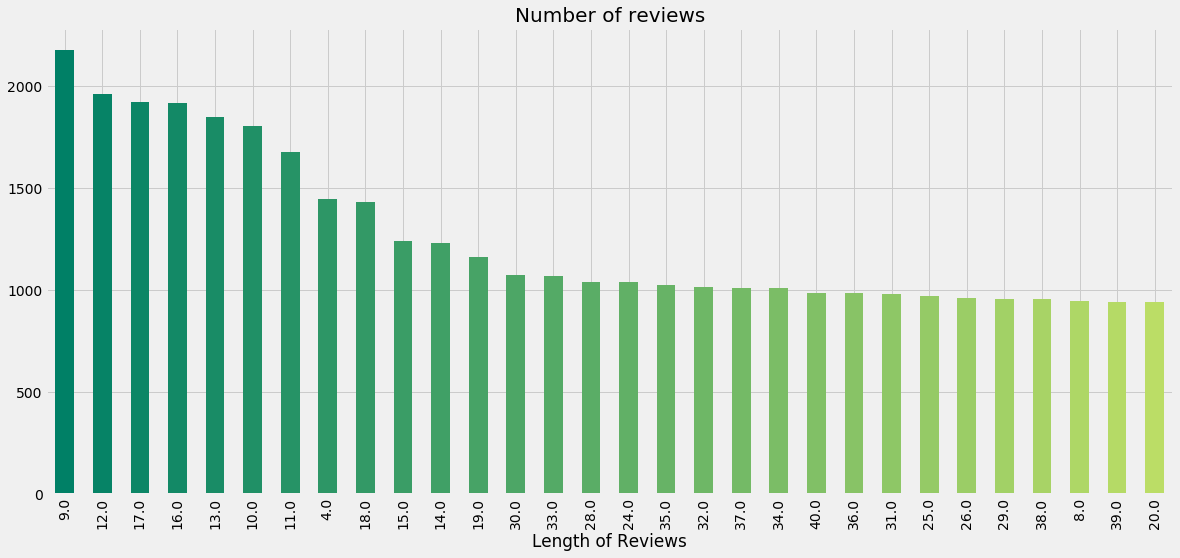

In [68]:
# визуализируем review по количеству символов
plt.rcParams['figure.figsize'] = (18, 8)
plt.style.use('fivethirtyeight')

color = plt.cm.summer(np.linspace(0, 2, 80))
reviews_eng_courses.review_text.str.len().sort_index().value_counts().head(30).plot.bar(color = color)
plt.title('Number of reviews', fontsize = 20, fontweight = 30)
plt.xlabel('Length of Reviews')
plt.show()

In [69]:
# девятисимвольных отзывов в датасете большинство
len(reviews_eng_courses[reviews_eng_courses.review_text.str.len()==9])

2176

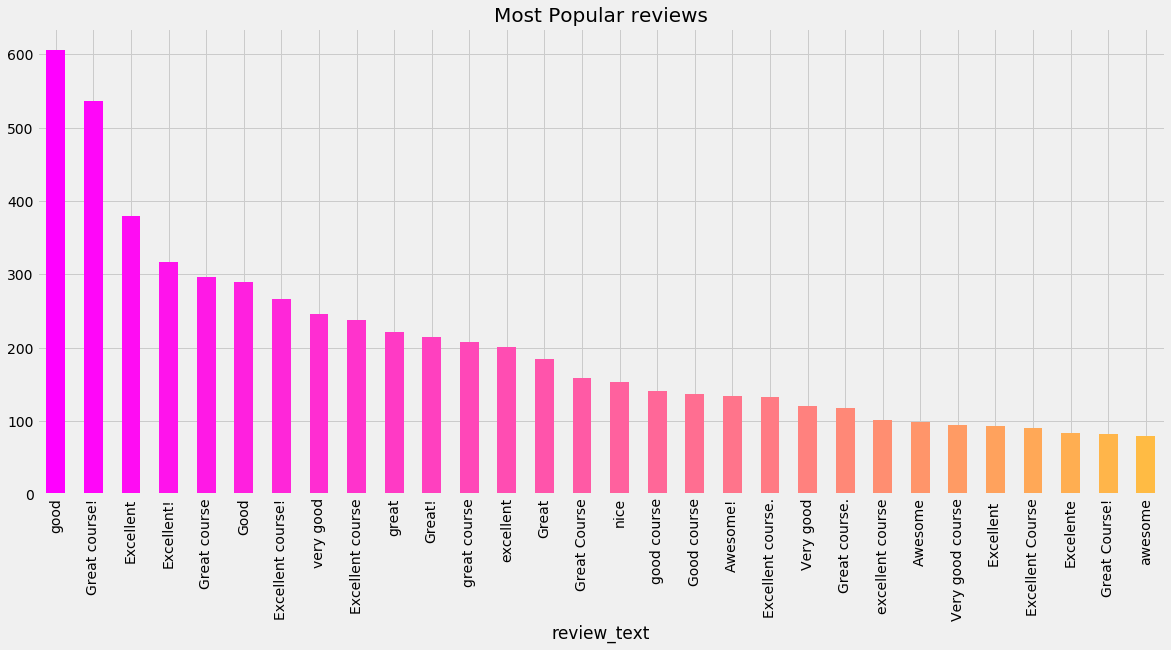

In [71]:
#визуализируем самые частые тексты отзывов

plt.rcParams['figure.figsize'] = (18, 8)
plt.style.use('fivethirtyeight')

color = plt.cm.spring(np.linspace(0, 2, 80))
reviews_eng_courses['review_text'].value_counts().head(30).plot.bar(color = color)
plt.title('Most Popular reviews', fontsize = 20, fontweight = 30)
plt.xlabel('review_text')
plt.show()

*Отзывы на курсы на разных языках, но очевидно, что большинство отзывов на английском, поэтому в дальнейшем будем применять библиотеки для работы с английским языком

In [83]:
#Пять вариантов "хороших" отзывов
for i, text in reviews_eng_courses[reviews_eng_courses.rating>=4].head(5).iterrows():
    print("Good review: \n {0} \n".format(text['review_text']))

Good review: 
 Very relevant and useful course designed for CIOs 

Good review: 
 Videos that are presented in French could've been translated to English.  

Good review: 
 Great piece of work, I especially liked a few 'lifehacks' for the CIO 

Good review: 
 Excellent course, for me it was very rewarding and the terms used and the tools given were excellent, and today and I put in use in my job, Thank you for inculcating knowledge and move on               

Good review: 
 Excellent... It is a representation of our day by day, thanks for sharing your vision, experience and advices...
Regards
Daniel Damas 



In [84]:
good_reviews_eng_courses = reviews_eng_courses[reviews_eng_courses.rating>=4]
good_reviews_eng_courses.head()

,course_id,reviewer_name,rating,review_text
0,2-speed-it,Ravish,5,Very relevant and useful course designed for CIOs
2,2-speed-it,Viswas P,4,Videos that are presented in French could've b...
4,2-speed-it,Konstantin A,5,"Great piece of work, I especially liked a few ..."
5,2-speed-it,Eduardo F,5,"Excellent course, for me it was very rewarding..."
6,2-speed-it,Daniel D,4,Excellent... It is a representation of our day...


In [85]:
#Пять вариантов "плохих" отзывов
for i, text in reviews_eng_courses[reviews_eng_courses.rating<=3].head(5).iterrows():
    print("Bad review: \n {0} \n".format(text['review_text']))

Bad review: 
 This course does not say anything about digitization which is the core subject of the digital wave. 

Bad review: 
 The course content is quite good, though it could have been deeper in some areas. But its peer review system is not working well, if at all. Regards, An Le. 

Bad review: 
 My expectation from the course was huge as many people told me coursera classes are great etc. However I found this course is a huge let down for me. The content was too primitive and generic, more suitable for one with non IT background. The content is not deep and rich. Apart from that, some of the videos are in non-english voice. Atleast those should have an english voice over than having just a sub titles. Some of the videos are mere waste of time and useless. I am not going to recommend this course atleast to any of my colleague. I hope the other courses are better. Some other courses seems interesting, but now I am doubtful to take those. Thinking of other options.  

Bad review: 
 

In [86]:
bad_reviews_eng_courses = reviews_eng_courses[reviews_eng_courses.rating<=3]
bad_reviews_eng_courses.head()

,course_id,reviewer_name,rating,review_text
1,2-speed-it,Etienne R,2,This course does not say anything about digiti...
3,2-speed-it,AN L,3,"The course content is quite good, though it co..."
12,2-speed-it,Kedarnath P,2,My expectation from the course was huge as man...
20,2-speed-it,Tom H,3,I was disappointed because the name is mislead...
27,2-speed-it,Marcel B,3,"Good content, but the course setting does (at ..."


# Токенизация и очистка данных
Сделаем токенизацию слов из текстов review

In [87]:
import re

from nltk.corpus import stopwords
from nltk.stem.snowball import EnglishStemmer

In [180]:
mystopwords = stopwords.words('english') + ["i'm", '-', "i've"] + ["\\", "\"", "'", "\'"] + ['assignments','many','get','one','way','courses','lot','much','could','really', 'would','also', 'course']
regex = re.compile("['A-Za-z\-]+")

def tokenize(text, regex=regex, stopwords=mystopwords):
    """ Tokenize all tokens from text string
        Returns array of tokens
    """
    try:
        text = " ".join(regex.findall(text)).lower()
        tokens = ' '.join([token for token in text.split(' ') if not token in stopwords])
        return tokens
    except:
        return []

In [181]:
reviews_eng_courses['review_text_tokenize'] = reviews_eng_courses.review_text.apply(tokenize)

In [182]:
reviews_eng_courses['review_text_tokenize']

0                             relevant useful designed cios
1         say anything digitization core subject digital...
2         videos presented french could've translated en...
3         content quite good though deeper areas peer re...
4         great piece work especially liked 'lifehacks' cio
5         excellent rewarding terms used tools given exc...
6         excellent representation day day thanks sharin...
7                            interesting well-designed mooc
8         completion progress well reviews taking time t...
9         nice macro ideias several areas pretty consist...
10        liked presentation slides clear concise subjec...
11        un cours vraiment int ressant qui fait chos de...
12        expectation huge people told coursera classes ...
13        helpful understanding strategy organisations p...
14        excellent learned role challenges cio's face h...
15        insightful transformations backed solid number...
16                                      

In [183]:
reviews_eng_courses.head(2)

,course_id,reviewer_name,rating,review_text,review_text_tokenize
0,2-speed-it,Ravish,5,Very relevant and useful course designed for CIOs,relevant useful designed cios
1,2-speed-it,Etienne R,2,This course does not say anything about digiti...,say anything digitization core subject digital...


In [184]:
reviews_eng_courses['review_text_tokenize'] = reviews_eng_courses['review_text_tokenize'].astype(str)


In [185]:
good_reviews_eng_courses = reviews_eng_courses[reviews_eng_courses.rating>=4]
good_reviews_eng_courses.head(2)

,course_id,reviewer_name,rating,review_text,review_text_tokenize
0,2-speed-it,Ravish,5,Very relevant and useful course designed for CIOs,relevant useful designed cios
2,2-speed-it,Viswas P,4,Videos that are presented in French could've b...,videos presented french could've translated en...


In [186]:
len(good_reviews_eng_courses)

143655

In [187]:
bad_reviews_eng_courses = reviews_eng_courses[reviews_eng_courses.rating<=3]
bad_reviews_eng_courses.head(2)

,course_id,reviewer_name,rating,review_text,review_text_tokenize
1,2-speed-it,Etienne R,2,This course does not say anything about digiti...,say anything digitization core subject digital...
3,2-speed-it,AN L,3,"The course content is quite good, though it co...",content quite good though deeper areas peer re...


In [188]:
len(bad_reviews_eng_courses)

14283

In [189]:
### Определим частоту слов построим облако слов для хороших и для плохих отзывов

In [190]:
from collections import Counter

lemmata = []
for index, row in bad_reviews_eng_courses.iterrows():
    lemmata += row['review_text_tokenize'].split()
cnt_bad = Counter(lemmata)

for i in cnt_bad.most_common(15):
    print(i)

('good', 3166)
('like', 1978)
('content', 1899)
('material', 1854)
('time', 1838)
('videos', 1772)
('lectures', 1580)
('week', 1486)
('interesting', 1359)
('information', 1289)
('better', 1174)
('understand', 1148)
('questions', 1143)
('assignment', 1139)
('well', 1118)


In [191]:
# Количество слов в словаре:
print(len(cnt_bad))

19876


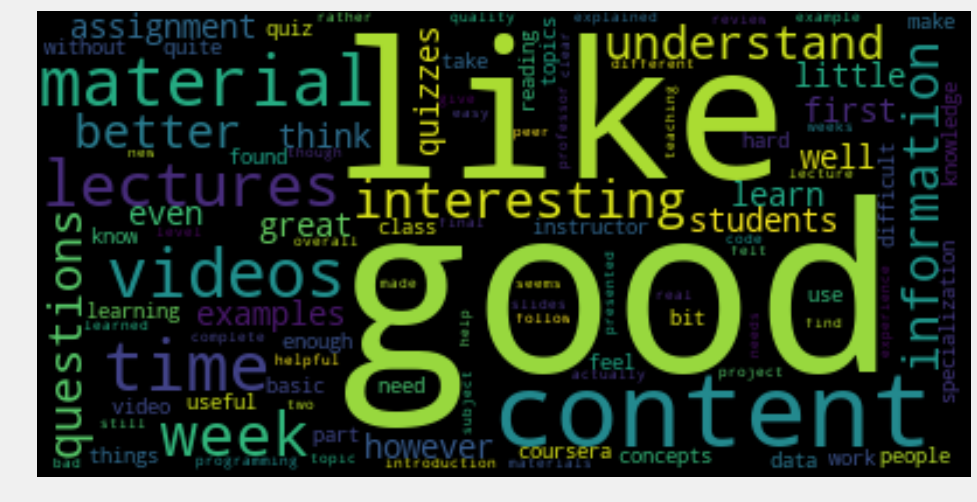

In [192]:
from wordcloud import *
word_freq = [i for i in cnt_bad.most_common(100)]
wd = WordCloud(background_color = 'black')
wd.generate_from_frequencies(dict(word_freq))
plt.figure()
plt.imshow(wd, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [193]:
from collections import Counter

lemmata = []
for index, row in good_reviews_eng_courses.iterrows():
    lemmata += row['review_text_tokenize'].split()
cnt_good = Counter(lemmata)

for i in cnt_good.most_common(15):
    print(i)

('great', 32370)
('good', 26594)
('excellent', 15658)
('well', 12855)
('interesting', 11505)
('thank', 11369)
('useful', 8548)
('learn', 8400)
('thanks', 7870)
('understand', 7647)
('learning', 7501)
('like', 7381)
('learned', 7281)
('recommend', 6629)
('knowledge', 6559)


In [194]:
# Количество слов в словаре:
print(len(cnt_good))

48070


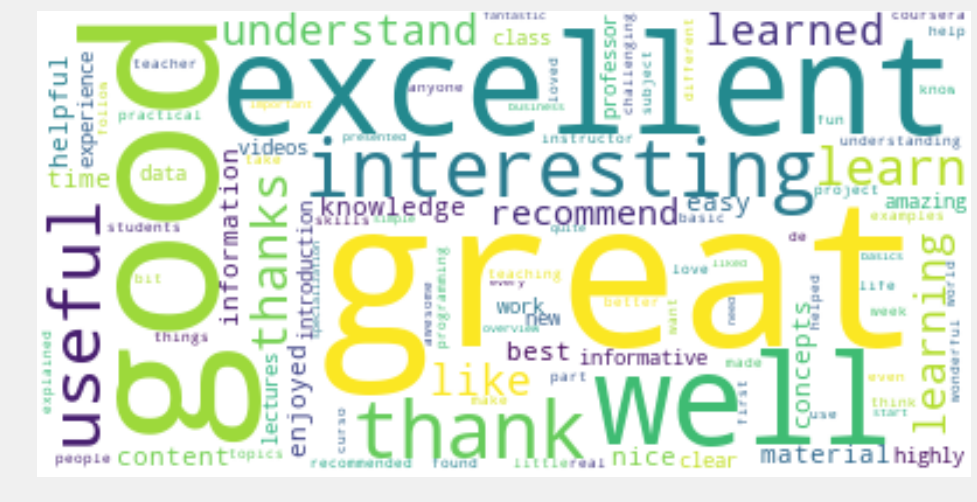

In [195]:
from wordcloud import *
word_freq = [i for i in cnt_good.most_common(100)]
wd = WordCloud(background_color = 'white')
wd.generate_from_frequencies(dict(word_freq))
plt.figure()
plt.imshow(wd, interpolation = 'bilinear')
plt.axis('off')
plt.show()